In [1]:
import scanpy as sc
import pandas as pd
import numpy as np

In [2]:
male = male = sc.read_h5ad("cleaned_data/male_gonadal.h5ad")
female = sc.read_h5ad("cleaned_data/female_gonadal.h5ad")

In [3]:
def get_array(adata: sc.AnnData):
    sorted_genes = sorted(adata.var_names)
    df = pd.DataFrame(adata.X.toarray(), index=adata.obs_names, columns=sorted_genes)
    df2 = adata.obs['cell_type']
    df.sort_index(inplace=True)
    df2.sort_index(inplace=True)

    X = df.to_numpy()
    y = df2.to_numpy()
    return X, y, sorted_genes

In [4]:
male_X, male_y, sorted_genes = get_array(male)
female_X, female_y, _ = get_array(female)

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(male_y)

male_y = le.transform(male_y)
female_y = le.transform(female_y)

In [6]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)
ohe.fit(male_y.reshape(-1, 1))

male_y_onehot = ohe.transform(male_y.reshape(-1, 1))
female_y_onehot = ohe.transform(female_y.reshape(-1, 1))

In [7]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

def balanced_sc_resample(X, y, target_count=2000, k_neighbors=5):
    """
    Memory-optimized class balancing for scRNA-seq data with cluster-aware sampling
    Maintains original data dtype and avoids unnecessary copies
    """
    original_y_shape = y.shape
    if y.ndim == 2:
        n_classes = y.shape[1]
        y_labels = np.argmax(y, axis=1)  # Convert to 1D class indices
    else:
        y_labels = y.copy()

    unique_classes, counts = np.unique(y_labels, return_counts=True)
    X_resampled = []
    y_resampled = []
    
    for cls, count in zip(unique_classes, counts):
        cls_mask = (y_labels == cls)
        X_cls = X[cls_mask]
        
        # Cluster-based undersampling for large classes
        if count > target_count:
            # Prototype selection with batch processing
            n_clusters = max(1, target_count // 100)
            kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X_cls)
            
            # Find closest real cells to centroids
            centroids = kmeans.cluster_centers_
            dist_chunks = [cdist(X_cls[i::10], centroids) for i in range(10)]
            closest_idx = np.argmin(np.vstack(dist_chunks), axis=0)
            selected = X_cls[closest_idx]
            
            # Memory-efficient sampling
            select_idx = np.random.choice(
                selected.shape[0],
                target_count,
                replace=selected.shape[0] < target_count
            )
            X_resampled.append(selected[select_idx])
            
        # Vectorized oversampling for small classes
        else:
            n_neighbors = min(k_neighbors, count-1) if count > 1 else 0
            n_synthetic = target_count - count
            
            if n_neighbors > 0:
                # Generate all synthetic samples in one batch
                neighbor_idx = np.random.choice(
                    count,
                    size=(n_synthetic, n_neighbors+1),
                    replace=True  # Allow reuse for small populations
                )
                weights = np.random.dirichlet(np.ones(n_neighbors+1), n_synthetic)
                synthetic = np.einsum('ij,ijk->ik', weights, X_cls[neighbor_idx])
            else:
                # Handle single-cell case with duplication
                synthetic = np.tile(X_cls, (n_synthetic, 1))
            
            X_resampled.append(np.vstack([X_cls, synthetic]))
        
        y_resampled.append(np.full(target_count, cls))

    y_balanced = np.concatenate(y_resampled)
    if len(original_y_shape) == 2:
        # Recreate one-hot encoding with original class dimensions
        y_balanced = np.eye(n_classes)[y_balanced.astype(int)]
    
    return np.vstack(X_resampled), y_balanced

In [8]:
import numpy as np
from sklearn.preprocessing import normalize

class GFICFTransformer:
    def __init__(self):
        self.icf = None
        self.fitted_genes = None

    def fit(self, train_X, sorted_genes):
        """Calculate ICF weights from training data"""
        # Gene Frequency (L1 normalization)
        gf_train = normalize(train_X, norm='l1', axis=1)
        
        # Inverse Cell Frequency (from training)
        n_cells = train_X.shape[0]
        gene_presence = (gf_train > 0).sum(axis=0)
        self.icf = np.log((n_cells + 1) / (gene_presence + 1)) + 1  # Smoothing
        self.fitted_genes = np.array(sorted_genes)
        return self

    def transform(self, X, sorted_genes):
        """Apply precomputed ICF to new data"""
        # Ensure gene order matches training
        if not np.array_equal(sorted_genes, self.fitted_genes):
            raise ValueError("Gene order/selection must match training data")
            
        gf_new = normalize(X, norm='l1', axis=1)
        return gf_new * self.icf  # Element-wise multiplication

In [9]:
gficf = GFICFTransformer()
gficf.fit(male_X, sorted_genes)

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(male_X, male_y_onehot, test_size=0.2, random_state=42, stratify=male_y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((19701, 23333),
 (4926, 23333),
 (6157, 23333),
 (19701, 8),
 (4926, 8),
 (6157, 8))

In [11]:
X_train_resampled, y_train_resampled = balanced_sc_resample(X_train, y_train, target_count=12000, k_neighbors=5)
X_train_resampled.shape, y_train_resampled.shape

((96000, 23333), (96000, 8))

In [12]:
# Shuffle the data
from sklearn.utils import shuffle

X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled)

In [13]:
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, classification_report

class scRNADataset(torch.utils.data.Dataset):
    def __init__(self, X, y, gficf: GFICFTransformer):
        self.gficf = gficf

        self.X = gficf.transform(X, gficf.fitted_genes)  # Apply ICF transformation

        self.X = torch.from_numpy(self.X).float()  # Convert sparse matrix to dense
        self.y = torch.from_numpy(y).float()
        self.input_size = self.X[0].shape
        self.n_classes = y.shape[1]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [14]:
train_dataset = scRNADataset(X_train_resampled, y_train_resampled, gficf)
val_dataset = scRNADataset(X_val, y_val, gficf)
test_dataset = scRNADataset(X_test, y_test, gficf)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [15]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=128.0, m=0.10):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label):
        weight = F.normalize(self.weight, p=2, dim=1)

        cosine = F.linear(input, weight)  # Equivalent to cos(θ)
        cosine = cosine.clamp(-1.0 + 1e-7, 1.0 - 1e-7)  # Numerical stability

        theta = torch.acos(cosine)
        target_theta = theta + self.m  # Add margin to the target class
        target_cosine = torch.cos(target_theta)

        one_hot = F.one_hot(label, num_classes=self.out_features).float()
        output = one_hot * target_cosine + (1 - one_hot) * cosine  # Apply margin to target class

        # Feature scaling
        output *= self.s
        return output
    
class Embedding(nn.Module):
    def __init__(self, out_features, input_size=(14461, )):
        super(Embedding, self).__init__()

        self.fc1 = nn.Linear(input_size[0], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, out_features=out_features)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        

In [16]:
class ArcFaceClassifier(nn.Module):
    def __init__(self, embedding: Embedding, arcface: ArcFace):
        super(ArcFaceClassifier, self).__init__()
        self.embedding: Embedding = embedding
        self.arcface: ArcFace = arcface

    def forward(self, x, label):
        x = self.embedding(x)        
        x = F.normalize(x, p=2, dim=1)  # Normalize embeddings
        x = self.arcface(x, label)
        return x

In [17]:
embedding = Embedding(out_features=3, input_size=train_dataset.input_size)
arcface = ArcFace(in_features=3, out_features=train_dataset.n_classes)

model = ArcFaceClassifier(embedding, arcface)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

ArcFaceClassifier(
  (embedding): Embedding(
    (fc1): Linear(in_features=23333, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=256, out_features=3, bias=True)
  )
  (arcface): ArcFace()
)

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [20]:
for epoch in range(50):
    model.train()
    epoch_loss = 0.0
    for i, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = model(X, y.argmax(dim=1))
        loss = criterion(output, y.argmax(dim=1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # print(f"Epoch: {epoch}, Iteration: {i}, Loss: {loss.item()}")
    print(f"Epoch: {epoch}, Loss: {epoch_loss / len(train_loader)}")

    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            output = model(X, y.argmax(dim=1))
            loss = criterion(output, y)
            val_loss += loss.item()
            val_preds.append(output.cpu().numpy())
            val_labels.append(y.cpu().numpy())
    val_preds = np.concatenate(val_preds, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    val_preds = np.argmax(val_preds, axis=1)
    val_labels = np.argmax(val_labels, axis=1)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')
    print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {val_accuracy}, F1 Score: {val_f1}")

    if epoch_loss / len(train_loader) < 1e-8:
        print("Early stopping")
        break

100%|██████████| 1500/1500 [00:11<00:00, 131.46it/s]


Epoch: 0, Loss: 4.370391422016148
Validation Loss: 1.0330223297917998, Accuracy: 0.8883475436459602, F1 Score: 0.8888161185429296


100%|██████████| 1500/1500 [00:08<00:00, 176.40it/s]


Epoch: 1, Loss: 0.12760438581820685
Validation Loss: 1.2423848169190543, Accuracy: 0.8583028826634186, F1 Score: 0.8554718270345274


100%|██████████| 1500/1500 [00:08<00:00, 175.65it/s]


Epoch: 2, Loss: 0.08023633296596745
Validation Loss: 0.7175361917583973, Accuracy: 0.928136419001218, F1 Score: 0.9285381177567484


100%|██████████| 1500/1500 [00:08<00:00, 175.82it/s]


Epoch: 3, Loss: 0.055712473562347896
Validation Loss: 0.6657372137241355, Accuracy: 0.9330085261875761, F1 Score: 0.9331220303776346


100%|██████████| 1500/1500 [00:08<00:00, 176.87it/s]


Epoch: 4, Loss: 0.042567230373158814
Validation Loss: 0.8413162297242648, Accuracy: 0.9173771822980106, F1 Score: 0.9157752638815606


100%|██████████| 1500/1500 [00:08<00:00, 182.11it/s]


Epoch: 5, Loss: 0.02006465140962238
Validation Loss: 0.5939775566213655, Accuracy: 0.9330085261875761, F1 Score: 0.9334297224750417


100%|██████████| 1500/1500 [00:08<00:00, 181.55it/s]


Epoch: 6, Loss: 0.02228952672899547
Validation Loss: 0.6719147115462012, Accuracy: 0.9299634591961023, F1 Score: 0.9293881539032192


100%|██████████| 1500/1500 [00:08<00:00, 179.41it/s]


Epoch: 7, Loss: 0.01663236308040469
Validation Loss: 0.841709106854411, Accuracy: 0.915347137637028, F1 Score: 0.9166548168467081


100%|██████████| 1500/1500 [00:08<00:00, 180.69it/s]


Epoch: 8, Loss: 0.006390139824430946
Validation Loss: 0.8081028982996941, Accuracy: 0.9293544457978076, F1 Score: 0.9284619397953471


100%|██████████| 1500/1500 [00:08<00:00, 181.58it/s]


Epoch: 9, Loss: 0.021540771663525107
Validation Loss: 0.649089378714501, Accuracy: 0.9425497360941941, F1 Score: 0.942397320451201


100%|██████████| 1500/1500 [00:08<00:00, 182.44it/s]


Epoch: 10, Loss: 0.005804315897527637
Validation Loss: 0.6211957780087923, Accuracy: 0.9439707673568819, F1 Score: 0.9438842144681314


100%|██████████| 1500/1500 [00:08<00:00, 177.31it/s]


Epoch: 11, Loss: 0.009486601070248573
Validation Loss: 0.6297703329110881, Accuracy: 0.9368656110434429, F1 Score: 0.9367638303753547


100%|██████████| 1500/1500 [00:08<00:00, 177.11it/s]


Epoch: 12, Loss: 0.016999686762662777
Validation Loss: 0.6520970314166618, Accuracy: 0.9259033698741372, F1 Score: 0.9267789197548629


100%|██████████| 1500/1500 [00:08<00:00, 173.73it/s]


Epoch: 13, Loss: 0.0075403932948802065
Validation Loss: 0.5903453578247972, Accuracy: 0.9443767762890783, F1 Score: 0.9444524859019388


100%|██████████| 1500/1500 [00:08<00:00, 171.99it/s]


Epoch: 14, Loss: 0.004486512851778452
Validation Loss: 0.7361473208656172, Accuracy: 0.9445797807551766, F1 Score: 0.9437766486886084


100%|██████████| 1500/1500 [00:08<00:00, 171.89it/s]


Epoch: 15, Loss: 0.011011214840007336
Validation Loss: 0.6980339970240104, Accuracy: 0.9415347137637028, F1 Score: 0.9413639093032385


100%|██████████| 1500/1500 [00:08<00:00, 169.93it/s]


Epoch: 16, Loss: 0.002147221524509998
Validation Loss: 0.6519328559568914, Accuracy: 0.9484368656110435, F1 Score: 0.948263188818752


100%|██████████| 1500/1500 [00:08<00:00, 170.44it/s]


Epoch: 17, Loss: 0.001243662508109858
Validation Loss: 0.6835822372439517, Accuracy: 0.9482338611449452, F1 Score: 0.9480915508998328


100%|██████████| 1500/1500 [00:08<00:00, 174.12it/s]


Epoch: 18, Loss: 0.014892365289104268
Validation Loss: 1.2160212661732326, Accuracy: 0.9155501421031262, F1 Score: 0.9133404112663336


100%|██████████| 1500/1500 [00:08<00:00, 174.43it/s]


Epoch: 19, Loss: 0.005738658394732171
Validation Loss: 0.6777447620074132, Accuracy: 0.9476248477466505, F1 Score: 0.9474977163099257


100%|██████████| 1500/1500 [00:08<00:00, 171.65it/s]


Epoch: 20, Loss: 0.002202112528546356
Validation Loss: 0.6736082041338646, Accuracy: 0.9488428745432399, F1 Score: 0.9488854782692832


100%|██████████| 1500/1500 [00:08<00:00, 174.34it/s]


Epoch: 21, Loss: 0.0018878466048271735
Validation Loss: 0.7103739698348883, Accuracy: 0.9494518879415347, F1 Score: 0.9494612823630597


100%|██████████| 1500/1500 [00:08<00:00, 173.21it/s]


Epoch: 22, Loss: 0.008154534431287887
Validation Loss: 0.6021391355928469, Accuracy: 0.9453917986195697, F1 Score: 0.9449688990043634


100%|██████████| 1500/1500 [00:08<00:00, 173.08it/s]


Epoch: 23, Loss: 0.0001972336465109
Validation Loss: 0.6244040502943234, Accuracy: 0.9508729192042225, F1 Score: 0.95089449881547


100%|██████████| 1500/1500 [00:08<00:00, 174.18it/s]


Epoch: 24, Loss: 8.637598254049787e-06
Validation Loss: 0.6684907937811044, Accuracy: 0.9524969549330086, F1 Score: 0.9524507778208365


100%|██████████| 1500/1500 [00:08<00:00, 173.40it/s]


Epoch: 25, Loss: 0.0015491631562913983
Validation Loss: 1.1926601126838428, Accuracy: 0.9064149411287048, F1 Score: 0.9081446931509745


100%|██████████| 1500/1500 [00:08<00:00, 173.02it/s]


Epoch: 26, Loss: 0.008293704600611726
Validation Loss: 0.6391080181528632, Accuracy: 0.9480308566788469, F1 Score: 0.9477150735976284


100%|██████████| 1500/1500 [00:08<00:00, 170.07it/s]


Epoch: 27, Loss: 0.0028881059186055325
Validation Loss: 0.7341390838784789, Accuracy: 0.9466098254161591, F1 Score: 0.9471340871805422


100%|██████████| 1500/1500 [00:09<00:00, 166.34it/s]


Epoch: 28, Loss: 0.01196034507804297
Validation Loss: 0.7260688058982827, Accuracy: 0.9478278522127487, F1 Score: 0.9479254764379792


100%|██████████| 1500/1500 [00:09<00:00, 157.67it/s]


Epoch: 29, Loss: 0.0015575850478811997
Validation Loss: 0.6908257019914853, Accuracy: 0.9462038164839627, F1 Score: 0.9462425864440153


100%|██████████| 1500/1500 [00:09<00:00, 156.71it/s]


Epoch: 30, Loss: 0.001953428845689094
Validation Loss: 0.8405110520588888, Accuracy: 0.9500609013398295, F1 Score: 0.9499139289642012


100%|██████████| 1500/1500 [00:09<00:00, 155.09it/s]


Epoch: 31, Loss: 1.6021386542047768e-05
Validation Loss: 0.7270389349115403, Accuracy: 0.9526999593991068, F1 Score: 0.9525645871267733


100%|██████████| 1500/1500 [00:09<00:00, 155.43it/s]


Epoch: 32, Loss: 1.1086891083668486e-06
Validation Loss: 0.7396591443274312, Accuracy: 0.9526999593991068, F1 Score: 0.952539434987681


100%|██████████| 1500/1500 [00:09<00:00, 156.99it/s]


Epoch: 33, Loss: 6.049327261580621e-07
Validation Loss: 0.7492033117958378, Accuracy: 0.9526999593991068, F1 Score: 0.952571252959747


100%|██████████| 1500/1500 [00:09<00:00, 157.11it/s]


Epoch: 34, Loss: 3.445688388404496e-07
Validation Loss: 0.7598772821573474, Accuracy: 0.9531059683313033, F1 Score: 0.952987749785083


100%|██████████| 1500/1500 [00:09<00:00, 156.58it/s]


Epoch: 35, Loss: 2.0405607911936722e-07
Validation Loss: 0.7744572090896327, Accuracy: 0.9531059683313033, F1 Score: 0.9529666734786546


100%|██████████| 1500/1500 [00:09<00:00, 158.78it/s]


Epoch: 36, Loss: 9.957412851021215e-08
Validation Loss: 0.7895367938612365, Accuracy: 0.9533089727974016, F1 Score: 0.9531746371903266


100%|██████████| 1500/1500 [00:09<00:00, 160.36it/s]


Epoch: 37, Loss: 4.7957257178765645e-08
Validation Loss: 0.8072151342865538, Accuracy: 0.9524969549330086, F1 Score: 0.9523601383480282


100%|██████████| 1500/1500 [00:08<00:00, 170.02it/s]


Epoch: 38, Loss: 2.419302091483111e-08
Validation Loss: 0.82849985249217, Accuracy: 0.9524969549330086, F1 Score: 0.9523474083860379


100%|██████████| 1500/1500 [00:08<00:00, 169.04it/s]


Epoch: 39, Loss: 1.0928701069889968e-08
Validation Loss: 0.8445881784095163, Accuracy: 0.9531059683313033, F1 Score: 0.9529597087389166


100%|██████████| 1500/1500 [00:08<00:00, 168.73it/s]


Epoch: 40, Loss: 5.288658670258665e-09
Validation Loss: 0.8660533656547587, Accuracy: 0.953714981729598, F1 Score: 0.9535878769619308
Early stopping


In [21]:
class ArcFaceModel(nn.Module):
    def __init__(self, model: ArcFaceClassifier):
        super(ArcFaceModel, self).__init__()
        self.embedding = model.embedding
        self.fc = nn.Linear(model.arcface.in_features, model.arcface.out_features)

    def forward(self, x):
        x = self.embedding(x)
        x = F.normalize(x, p=2, dim=1)  # Normalize embeddings
        x = self.fc(x)
        return x

In [22]:
predictor = ArcFaceModel(model)
predictor.to(device)

optimizer = torch.optim.Adam(predictor.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    predictor.train()
    epoch_loss = 0.0
    for i, (X, y) in tqdm(enumerate(train_loader), total=len(train_loader)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        output = predictor(X)
        loss = criterion(output, y.argmax(dim=1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch: {epoch}, Loss: {epoch_loss / len(train_loader)}")

    predictor.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)
            output = predictor(X)
            loss = criterion(output, y.argmax(dim=1))
            val_loss += loss.item()
            val_preds.append(output.cpu().numpy())
            val_labels.append(y.cpu().numpy())

    val_preds = np.concatenate(val_preds, axis=0)
    val_labels = np.concatenate(val_labels, axis=0)
    val_preds = np.argmax(val_preds, axis=1)
    val_labels = np.argmax(val_labels, axis=1)
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds, average='weighted')

    print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {val_accuracy}, F1 Score: {val_f1}")


100%|██████████| 1500/1500 [00:08<00:00, 176.12it/s]


Epoch: 0, Loss: 1.0681331911087035
Validation Loss: 0.6018373888808412, Accuracy: 0.9545269995939911, F1 Score: 0.9547837227189858


100%|██████████| 1500/1500 [00:07<00:00, 192.31it/s]


Epoch: 1, Loss: 0.3764120647013187
Validation Loss: 0.34955242992221536, Accuracy: 0.9555420219244823, F1 Score: 0.9551525986890137


100%|██████████| 1500/1500 [00:08<00:00, 184.87it/s]


Epoch: 2, Loss: 0.16514360484480858
Validation Loss: 0.22302846155770414, Accuracy: 0.9587900933820545, F1 Score: 0.9587808041454902


100%|██████████| 1500/1500 [00:08<00:00, 185.12it/s]


Epoch: 3, Loss: 0.08100068876892329
Validation Loss: 0.19066028771075336, Accuracy: 0.9587900933820545, F1 Score: 0.9587447675460218


100%|██████████| 1500/1500 [00:07<00:00, 196.99it/s]


Epoch: 4, Loss: 0.04179495318730672
Validation Loss: 0.1822697864724444, Accuracy: 0.9587900933820545, F1 Score: 0.9585190949228463


100%|██████████| 1500/1500 [00:07<00:00, 197.11it/s]


Epoch: 5, Loss: 0.022044897175083556
Validation Loss: 0.19033077949440325, Accuracy: 0.9593991067803491, F1 Score: 0.9592997440538584


100%|██████████| 1500/1500 [00:07<00:00, 194.99it/s]


Epoch: 6, Loss: 0.011765374123429258
Validation Loss: 0.20069731365550647, Accuracy: 0.9591961023142509, F1 Score: 0.959154074242124


100%|██████████| 1500/1500 [00:07<00:00, 194.71it/s]


Epoch: 7, Loss: 0.006317457800420622
Validation Loss: 0.21693757878519693, Accuracy: 0.9602111246447422, F1 Score: 0.960220078468101


100%|██████████| 1500/1500 [00:07<00:00, 189.19it/s]


Epoch: 8, Loss: 0.003402130441740155
Validation Loss: 0.23146052785858803, Accuracy: 0.9596021112464475, F1 Score: 0.9595952895894758


100%|██████████| 1500/1500 [00:07<00:00, 188.68it/s]


Epoch: 9, Loss: 0.0018355660683785876
Validation Loss: 0.25060372811125275, Accuracy: 0.9600081201786439, F1 Score: 0.9599450705197723


100%|██████████| 1500/1500 [00:08<00:00, 185.41it/s]


Epoch: 10, Loss: 0.0009911822699941696
Validation Loss: 0.2694714934392772, Accuracy: 0.9589930978481527, F1 Score: 0.9589120836519212


100%|██████████| 1500/1500 [00:07<00:00, 189.85it/s]


Epoch: 11, Loss: 0.0005355619035156754
Validation Loss: 0.2860737851017318, Accuracy: 0.9587900933820545, F1 Score: 0.958681523645792


 13%|█▎        | 196/1500 [00:01<00:06, 188.55it/s]


KeyboardInterrupt: 

In [23]:
# Save the ArcFaceClassifier model
torch.save(model.state_dict(), "arcface_classifier_3.pth")

# Save the ArcFaceModel predictor
torch.save(predictor.state_dict(), "arcface_predictor_3.pth")

In [24]:
test_preds = []
test_labels = []
predictor.eval()
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        output = predictor(X)
        test_preds.append(output.cpu().numpy())
        test_labels.append(y.cpu().numpy())
test_preds = np.concatenate(test_preds, axis=0)
test_labels = np.concatenate(test_labels, axis=0)
test_preds = np.argmax(test_preds, axis=1)
test_labels = np.argmax(test_labels, axis=1)
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds, average='weighted')
print(f"Test Accuracy: {test_accuracy}, Test F1 Score: {test_f1}")
print(classification_report(test_labels, test_preds, target_names=[le.classes_[int(s.split('_')[1])] for s in ohe.get_feature_names_out()], zero_division=0))

Test Accuracy: 0.9572843917492285, Test F1 Score: 0.95731318431347
                       precision    recall  f1-score   support

     endothelial cell       0.98      1.00      0.99       167
      epithelial cell       0.93      0.94      0.93      1766
          erythrocyte       1.00      0.99      0.99        72
            germ cell       1.00      0.99      1.00       167
     mesenchymal cell       0.97      0.96      0.97      3128
          neural cell       0.99      1.00      1.00       260
skeletal muscle fiber       0.97      0.98      0.97       124
      supporting cell       0.93      0.91      0.92       473

             accuracy                           0.96      6157
            macro avg       0.97      0.97      0.97      6157
         weighted avg       0.96      0.96      0.96      6157



In [25]:
other_dataset = scRNADataset(female_X, female_y_onehot, gficf)
other_loader = torch.utils.data.DataLoader(other_dataset, batch_size=64, shuffle=False)

other_preds = []
other_labels = []
predictor.eval()

with torch.no_grad():
    for X, y in other_loader:
        X, y = X.to(device), y.to(device)
        output = predictor(X)
        other_preds.append(output.cpu().numpy())
        other_labels.append(y.cpu().numpy())
other_preds = np.concatenate(other_preds, axis=0)
other_labels = np.concatenate(other_labels, axis=0)

other_preds = np.argmax(other_preds, axis=1)
other_labels = np.argmax(other_labels, axis=1)

other_accuracy = accuracy_score(other_labels, other_preds)
other_f1 = f1_score(other_labels, other_preds, average='weighted')
print(f"Other Dataset Accuracy: {other_accuracy}, Other Dataset F1 Score: {other_f1}")
print(classification_report(other_labels, other_preds, target_names=[le.classes_[int(s.split('_')[1])] for s in ohe.get_feature_names_out()], zero_division=0))

Other Dataset Accuracy: 0.9351449275362319, Other Dataset F1 Score: 0.9375072346914683
                       precision    recall  f1-score   support

     endothelial cell       0.98      0.99      0.99      1371
      epithelial cell       0.83      0.98      0.90      5322
          erythrocyte       0.94      0.94      0.94       911
            germ cell       1.00      0.98      0.99      5373
     mesenchymal cell       0.98      0.89      0.93     14074
          neural cell       0.89      1.00      0.94       671
skeletal muscle fiber       0.57      0.93      0.71       834
      supporting cell       0.98      0.95      0.97      4564

             accuracy                           0.94     33120
            macro avg       0.90      0.96      0.92     33120
         weighted avg       0.95      0.94      0.94     33120



In [87]:
import plotly.graph_objs as go

import plotly.io as pio
pio.renderers.default = "browser"

# symbols = ['circle', 'square', 'diamond', 'star', 'pentagon', 'triangle']
# symbols = ['circle', 'circle-open', 'diamond', 'diamond-open', 'square', 'square-open']
symbols = ['circle', 'diamond', 'square']
symbols_3d = ['circle',  'diamond', 'square']
# colors = ['#fb5607', '#ff006e', '#8338ec', '#3a86ff', '#344e41', 
        #   '#ee6c4d', '#9d0208', '#8ac926', '#a53860', '#27187e']
colors = ['#003049', '#d62828', '#f77f00', '#ff006e', '#8338ec', 
          '#3a86ff', '#008000', '#49111c', '#00cc7a', '#6c3f18']

def plotly_3d_pca_plot(X_pca, y):
    df = pd.DataFrame(data={
        'x': X_pca[:, 0].tolist(),
        'y': X_pca[:, 1].tolist(),
        'z': X_pca[:, 2].tolist(),
        'class': y
    })

    fig = go.Figure(layout = go.Layout(
        paper_bgcolor='rgba(0,0,0,0)'
    ))
    for target in df['class'].unique():
        fig.add_trace(
            go.Scatter3d(
                # x=df[df['class']==target]['x'],
                x=-df[df['class']==target]['x'],
                y=df[df['class']==target]['y'],
                z=df[df['class']==target]['z'],
                mode='markers',
                marker=dict(
                    size=6,   # TODO To change 3D PCA Symbol size
                    symbol=symbols_3d[target % len(symbols_3d)],
                    color=colors[target % len(colors)],
                    opacity=1,
                    showscale=False
                ),
                name=le.classes_[target % len(le.classes_)],
            )
        )
    #  selecting the axis controls
    fig.update_layout(
        scene=dict(
            xaxis=dict(title=dict(text='PC1', font=dict(size=20, color='black')), linecolor='black', ticks='outside', 
                       ticklen=10, tickfont=dict(size=16, color ='black'), linewidth=2, gridcolor='#a68a64'),
            yaxis=dict(title=dict(text='PC2', font=dict(size=20, color='black')), tickangle=0, linecolor='rgb(0, 0, 0)', 
                       ticks='outside', ticklen=10, tickfont=dict(size=16, color ='black'), linewidth=2, 
                       gridcolor='#a68a64'),       
            zaxis=dict(title=dict(text='PC3', font=dict(size=20, color='black')), tickangle=0, linecolor='rgb(0, 0, 0)', 
                       ticks='outside', ticklen=10, tickfont=dict(size=16, color ='black'), 
                       linewidth=2, gridcolor='#a68a64'),       

            # xaxis=dict(showline=True, title='PCA Component 1', tickfont_size=14, title_font_size=16),
            # yaxis=dict(showline=True, title='PCA Component 2', tickfont_size=14, title_font_size=16),
            # zaxis=dict(showline=True, title='PCA Component 3', tickfont_size=14, title_font_size=16),
            bgcolor='white'
        ),
        title='3D PCA Plot',
        plot_bgcolor='rgb(255, 255, 255)',
        paper_bgcolor='rgb(255, 255, 255)',
        width=1000,
        height=1000,
        legend=dict(
            font=dict(size=16),
            itemsizing='constant',
            title='Class',
            bgcolor='rgba(0,0,0,0)'
        )
    )
    
    return fig

def plotly_2d_pca_plot(X_pca, y):
    """
    Plot 2D PCA visualization with consistent styling
    
    Parameters:
    -----------
    X_pca : numpy.ndarray
        The PCA coordinates of shape (n_samples, 2)
    y : numpy.ndarray
        Cell type labels
    """
    df = pd.DataFrame(data={
        'x': X_pca[:, 0].tolist(),
        'y': X_pca[:, 1].tolist(),
        'class': y
    })

    # Create figure with consistent styling
    fig = go.Figure()
    
    # Add traces for each cell type
    for target in sorted(df['class'].unique()):
        mask = df['class'] == target
        fig.add_trace(
            go.Scatter(
                x=df[mask]['x'],
                y=df[mask]['y'],
                mode='markers',
                marker=dict(
                    size=6,
                    symbol=symbols[target % len(symbols)],
                    color=colors[target % len(colors)],
                    opacity=0.9,
                    # line=dict(width=1, color='black'),
                ),
                name=le.classes_[target] if target < len(le.classes_) else f"Type {target}",
            )
        )

    # Update layout with consistent styling
    fig.update_layout(
        title=dict(
            text='2D TSNE Visualization',
            font=dict(size=22)
        ),
        xaxis=dict(
            title=dict(text='t-SNE1', font=dict(size=18)),
            showline=True,
            linecolor='black',
            mirror=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinecolor='lightgrey',
            tickfont=dict(size=14)
        ),
        yaxis=dict(
            title=dict(text='t-SNE2', font=dict(size=18)),
            showline=True,
            linecolor='black',
            mirror=True,
            gridcolor='lightgrey',
            zeroline=True,
            zerolinecolor='lightgrey',
            tickfont=dict(size=14)
        ),
        width=900,
        height=700,
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(
            font=dict(size=14),
            bordercolor='black',
            borderwidth=1,
            itemsizing='constant',
            title='Cell Type'
        ),
        margin=dict(l=80, r=80, t=100, b=80)
    )

    return fig


In [30]:
test_embeddings = []
test_labels = []

predictor.eval()

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        output = predictor.embedding(X)
        output = F.normalize(output, p=2, dim=1)
        test_embeddings.append(output.cpu().numpy())
        test_labels.append(y.cpu().numpy())


test_embeddings = np.concatenate(test_embeddings, axis=0)
test_embeddings = test_embeddings.reshape(-1, 3)
test_embeddings = test_embeddings / np.linalg.norm(test_embeddings, axis=1, keepdims=True)

test_labels = np.concatenate(test_labels, axis=0)
test_labels = np.argmax(test_labels, axis=1)

plotly_3d_pca_plot(test_embeddings, test_labels).show()

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(test_embeddings)

plotly_2d_pca_plot(X_tsne, test_labels).show()

In [97]:
import numpy as np
from Ensembl_converter import EnsemblConverter

def plot_gene_expression_on_tsne(gene_name, tsne_coords, expression_data, labels=None, title=None):
    """
    Plot gene expression on a t-SNE plot
    
    Parameters:
    -----------
    gene_name : str
        The gene name to plot
    tsne_coords : numpy.ndarray
        The t-SNE coordinates of shape (n_samples, 2)
    expression_data : numpy.ndarray
        Gene expression data of shape (n_samples, n_genes)
    labels : numpy.ndarray, optional
        Cell type labels for creating an outline
    title : str, optional
        Title for the plot
    """
    import plotly.graph_objects as go

    converter = EnsemblConverter()
    
    # Find gene index in sorted_genes
    if gene_name in sorted_genes:
        gene_idx = sorted_genes.index(gene_name)
    else:
        raise ValueError(f"Gene {gene_name} not found in sorted_genes")
    
    # Extract expression for this gene
    gene_expr = expression_data[:, gene_idx]
    
    # Create a colormap for the expression values
    colorscale = 'Viridis'  # Other options: 'Plasma', 'Inferno', 'Magma', 'Cividis'
    
    # Create figure
    fig = go.Figure()
    
    # If labels are provided, first plot cell type outlines
    if labels is not None:
        unique_labels = np.unique(labels)
        for label in unique_labels:
            mask = labels == label
            fig.add_trace(go.Scatter(
                x=tsne_coords[mask, 0],
                y=tsne_coords[mask, 1],
                mode='none',
                marker=dict(
                    size=10,
                    color='rgba(0,0,0,0)',  # Transparent fill
                    line=dict(width=1, color=colors[label % len(colors)]),
                ),
                name=le.classes_[label] if label < len(le.classes_) else f"Type {label}",
                showlegend=True
            ))

    gene_hugo = converter.convert_ids(genes=[gene_name])["Symbol"][0]
    
    # Add gene expression as colormap
    fig.add_trace(go.Scatter(
        x=tsne_coords[:, 0],
        y=tsne_coords[:, 1],
        mode='markers',
        marker=dict(
            size=6,
            color=gene_expr,  # Set color to gene expression
            colorscale=colorscale,
            showscale=True,
            colorbar=dict(
                title=gene_hugo,
                titleside="right",
                titlefont=dict(size=18),
                tickfont=dict(size=14)
            )
        ),
        name=gene_hugo,
        showlegend=False
    ))
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=title or f'Gene Expression: {gene_hugo} ({gene_name})',
            font=dict(size=22)
        ),
        xaxis=dict(
            title=dict(text='t-SNE 1', font=dict(size=18)),
            showline=True,
            linecolor='black',
            mirror=True,
            gridcolor='lightgrey',
            zeroline=False,
            tickfont=dict(size=14)
        ),
        yaxis=dict(
            title=dict(text='t-SNE 2', font=dict(size=18)),
            showline=True,
            linecolor='black',
            mirror=True,
            gridcolor='lightgrey',
            zeroline=False,
            tickfont=dict(size=14)
        ),
        width=900, 
        height=700,
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(
            font=dict(size=14, color='white'),
            bordercolor='black',
            borderwidth=0,
            itemsizing='constant'
        ),
        margin=dict(l=80, r=80, t=100, b=80)
    )
    
    return fig

# Example usage:
# To plot a specific gene (replace with an actual gene from sorted_genes)
# plot_gene_expression_on_tsne('ENSMUSG00000000001', X_tsne, X_test, test_labels).show()

# Function to search for genes by prefix
def find_genes_by_prefix(prefix, gene_list=sorted_genes):
    """Find genes that start with the given prefix"""
    matching_genes = [gene for gene in gene_list if gene.startswith(prefix)]
    return matching_genes[:10]  # Return up to 10 matches

In [122]:
plot_gene_expression_on_tsne('ENSMUSG00000002980', X_tsne, X_test, test_labels).show()

In [88]:
import torch
import torch.nn.functional as F
import numpy as np
import shap

# Select a background dataset (e.g. random subset of training examples)
background = torch.from_numpy(X_train[np.random.choice(X_train.shape[0], 100, replace=False)])
background = background.float().to(device)

test = torch.from_numpy(X_test).float().to(device)

# Use the GradientExplainer from SHAP (which works with torch models)
explainer = shap.GradientExplainer(predictor, background)

In [89]:
# Assume test is your test data as a NumPy array of shape (n_samples, n_features)
n_samples = test.shape[0]
chunk_size = 1  # Adjust the chunk size according to your memory/performance needs

# Initialize a list to accumulate the results for each output class.
shap_values_list = None

# Iterate over the rows in chunks while showing a tqdm progress bar.
for i in tqdm(range(0, n_samples, chunk_size), desc="Processing test rows"):
    chunk = test[i:i + chunk_size]
    # Compute SHAP values for this chunk
    chunk_shap = explainer.shap_values(chunk)
    
    if shap_values_list is None:
        # Initialize a list for each output if not already created.
        shap_values_list = [[chunk_val] for chunk_val in chunk_shap]
    else:
        # Append the new batch of SHAP values for each class.
        for j in range(len(chunk_shap)):
            shap_values_list[j].append(chunk_shap[j])

# At this point, shap_values_list is a list of arrays where each array has shape (n_samples, n_features)
print("Processed {} rows".format(len(shap_values_list[0])))

Processing test rows: 100%|██████████| 6157/6157 [1:29:10<00:00,  1.15it/s]

Processed 6157 rows


In [90]:
shap_values = np.array(shap_values_list[0])
shap_values.shape

(6157, 23333, 8)

In [98]:
import pickle

# Save the explainer
with open("explainer.pkl", "wb") as f:
    pickle.dump(explainer, f)

# Save the SHAP values
with open("shap_values.pkl", "wb") as f:
    pickle.dump(shap_values, f)

In [ ]:
import pickle

# Load the saved SHAP values and explainer

# Check if shap_values.pkl exists, and if so, load it
try:
    with open("shap_values.pkl", "rb") as f:
        shap_values = pickle.load(f)
    
    with open("explainer.pkl", "rb") as f:
        explainer = pickle.load(f)
    
    print(f"SHAP values loaded with shape: {shap_values.shape}")
except FileNotFoundError:
    print("SHAP values or explainer pickle files not found. Run cell 31-32 first.")
except Exception as e:
    print(f"Error loading SHAP values: {e}")

In [92]:
from Ensembl_converter import EnsemblConverter

# Convert one-hot test labels to integer labels for grouping
y_test_int = np.argmax(y_test, axis=1)
cell_type_marker_shap = {}
cell_type_marker_gene_symbol = {}
converter = EnsemblConverter()

# Loop over each cell type (using le.classes_ for names)
for class_idx, class_name in enumerate(le.classes_):
    indices = np.where(y_test_int == class_idx)[0]
    # For each class, select the corresponding SHAP values and average their absolute values
    class_shap = shap_values[indices, :, class_idx]  # shape [n_samples, num_genes]
    print(f"SHAP values for {class_name}:", class_shap.shape)
    mean_shap = np.mean(np.abs(class_shap), axis=0)
    # Get indices of the top 10 genes (largest average importance)
    top_indices = np.argsort(mean_shap)[-10:][::-1]
    cell_type_marker_shap[class_name] = [sorted_genes[i] for i in top_indices]
    print(f"Top 10 marker genes for {class_name} (via SHAP):", cell_type_marker_shap[class_name])

    # Convert Ensembl IDs to gene symbols
    gene_symbols = converter.convert_ids(cell_type_marker_shap[class_name])
    cell_type_marker_gene_symbol[class_name] = gene_symbols
    print(f"Gene symbols for {class_name}:")
    print(gene_symbols)
    print("\n\n")


SHAP values for endothelial cell: (167, 23333)
Top 10 marker genes for endothelial cell (via SHAP): ['ENSMUSG00000034845', 'ENSMUSG00000031871', 'ENSMUSG00000041378', 'ENSMUSG00000016494', 'ENSMUSG00000033191', 'ENSMUSG00000001946', 'ENSMUSG00000073599', 'ENSMUSG00000044338', 'ENSMUSG00000062960', 'ENSMUSG00000026921']
Gene symbols for endothelial cell:
                 ENSG Symbol
0  ENSMUSG00000034845  Plvap
1  ENSMUSG00000031871   Cdh5
2  ENSMUSG00000041378  Cldn5
3  ENSMUSG00000016494   Cd34
4  ENSMUSG00000033191   Tie1
5  ENSMUSG00000001946   Esam
6  ENSMUSG00000073599  Ecscr
7  ENSMUSG00000044338  Aplnr
8  ENSMUSG00000062960    Kdr
9  ENSMUSG00000026921  Egfl7



SHAP values for epithelial cell: (1766, 23333)
Top 10 marker genes for epithelial cell (via SHAP): ['ENSMUSG00000078302', 'ENSMUSG00000013584', 'ENSMUSG00000002980', 'ENSMUSG00000029309', 'ENSMUSG00000023043', 'ENSMUSG00000042985', 'ENSMUSG00000043969', 'ENSMUSG00000004231', 'ENSMUSG00000022865', 'ENSMUSG00000039385']
Ge

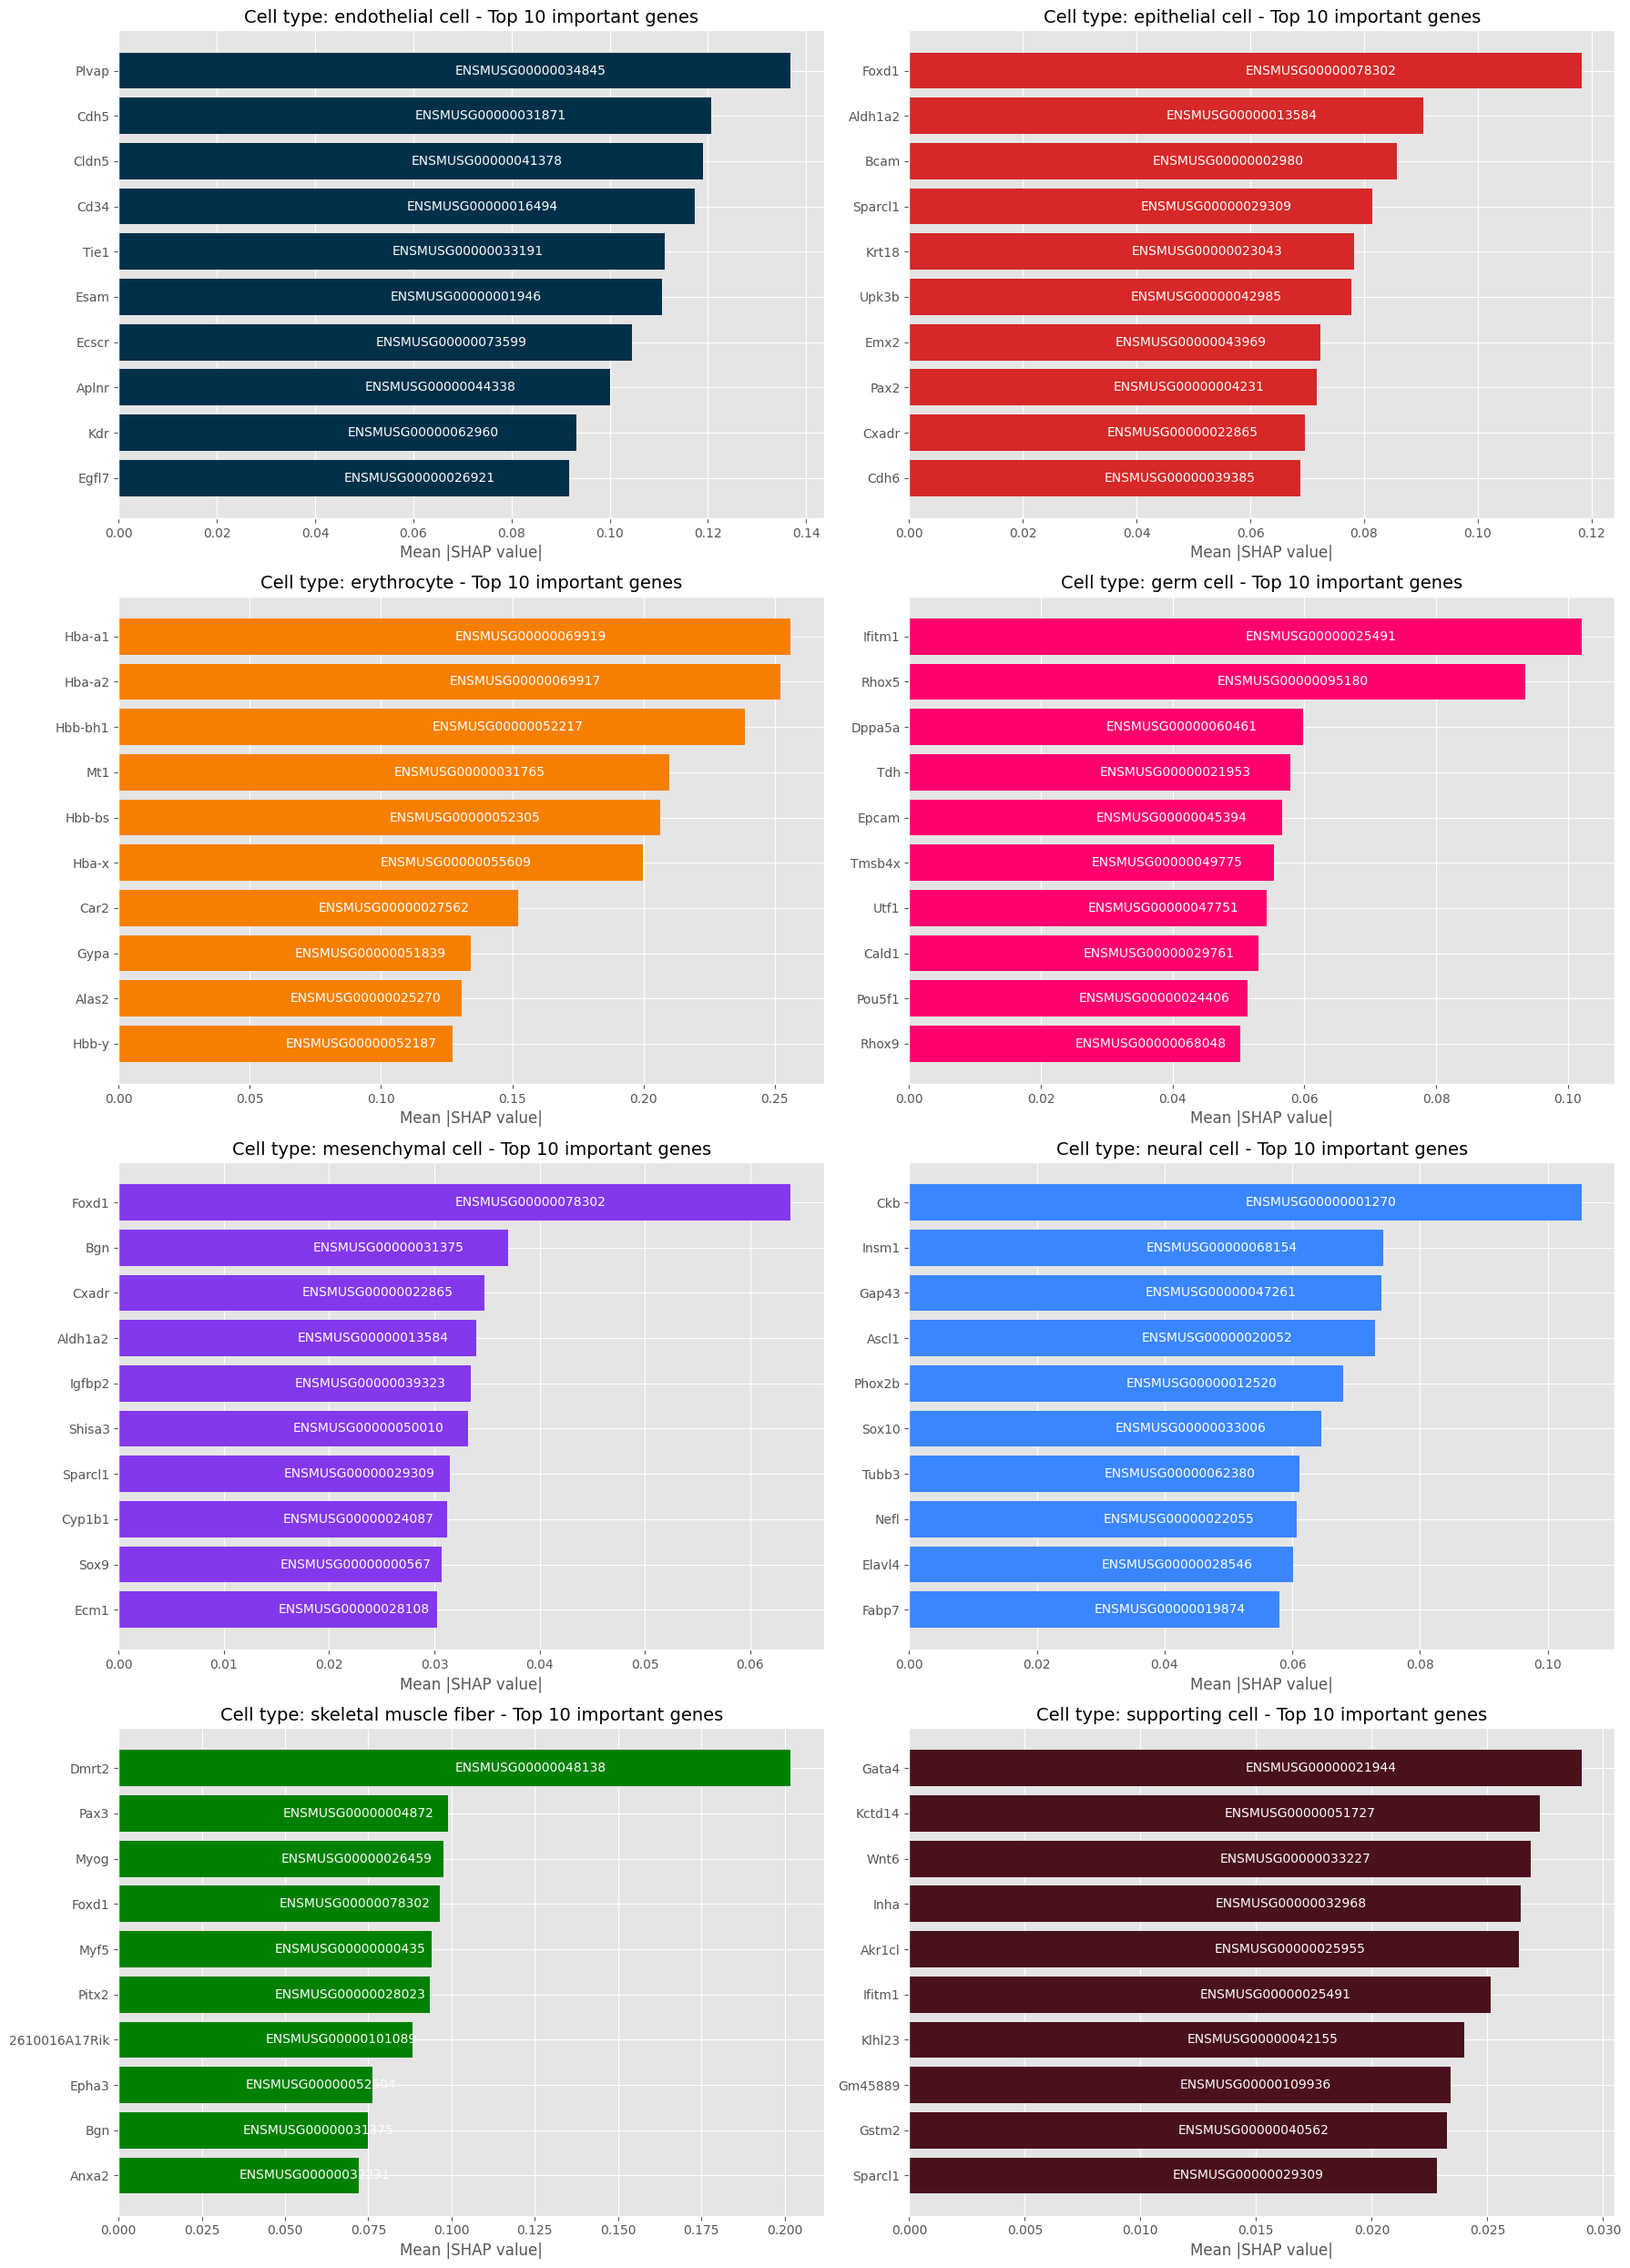

In [119]:
import numpy as np
from Ensembl_converter import EnsemblConverter

import matplotlib.pyplot as plt

# Convert one-hot test labels to integer labels for grouping
y_test_int = np.argmax(y_test, axis=1)
converter = EnsemblConverter()

# Set up the figure size and styling
plt.style.use('ggplot')
plt.figure(figsize=(18, 25))

# Loop over each cell type
for class_idx, class_name in enumerate(le.classes_):
    indices = np.where(y_test_int == class_idx)[0]
    
    # Skip if no samples for this class
    if len(indices) == 0:
        continue
    
    # For each class, select the corresponding SHAP values and average their absolute values
    class_shap = shap_values[indices, :, class_idx]  # shape [n_samples, num_genes]
    mean_shap = np.mean(np.abs(class_shap), axis=0)
    
    # Get indices of the top 10 genes (largest average importance)
    top_indices = np.argsort(mean_shap)[-10:]
    top_genes = [sorted_genes[i] for i in top_indices]
    
    # Convert Ensembl IDs to gene symbols
    gene_info = converter.convert_ids(top_genes)
    gene_symbols = gene_info["Symbol"].values
    
    # Create a subplot for this cell type
    plt.subplot(4, 2, class_idx + 1)
    
    # Create horizontal bar plot
    y_pos = np.arange(len(top_indices))
    plt.barh(y_pos, mean_shap[top_indices], align='center', color=colors[class_idx % len(colors)])
    
    # Set labels and titles
    plt.yticks(y_pos, gene_symbols)
    plt.xlabel('Mean |SHAP value|')
    plt.title(f'Cell type: {class_name} - Top 10 important genes', fontsize=14)
    
    # Add Ensembl IDs as small text
    for i, gene_id in enumerate(top_genes):
        plt.text(mean_shap[top_indices[i]]/2, i, gene_id, 
                 fontsize=10, color='white', va='center', alpha=1)
    
    plt.tight_layout()

plt.subplots_adjust(hspace=0.4)
plt.tight_layout()
plt.savefig("cell_type_markers_shap.png", dpi=300, bbox_inches='tight')
plt.show()